In [1]:
from ekpy import analysis
import numpy as np
import scipy.integrate as it
from scipy.signal import find_peaks, savgol_filter, peak_widths
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
data = pd.read_csv(r"C:\Users\geofr\Desktop\Research\Ferroelectrics\Test Sample Data BTO\Jesse PUND 1ms with preset.txt", skiprows=51, skipfooter=19, encoding='mbcs')
data

C:\Users\geofr\AppData\Local\Temp\ipykernel_11068\3186997117.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(r"C:\Users\geofr\Desktop\Research\Ferroelectrics\Test Sample Data BTO\Jesse PUND 1ms with preset.txt", skiprows=51, skipfooter=19, encoding='mbcs')


,Point,Time (ms),Drive Voltage,Measured Polarization (µC/cm2),Capacitance (µF),Normalized Capacitance (µF/cm2),Dielectric Constant,Instantaneous Current (mA)
0,1,0.0000,-0.0205,-20.299144,17.623298,176232.980748,5.970935,-0.011579
1,2,0.0005,-0.0430,-20.357036,17.623298,176232.980748,5.970935,-0.011579
2,3,0.0010,-0.0636,-20.400561,13.249633,132496.328592,4.489097,-0.008705
3,4,0.0015,-0.0820,-20.437325,11.191437,111914.374636,3.791762,-0.007353
4,5,0.0020,-0.1031,-20.510853,22.382875,223828.749271,7.583523,-0.014706
...,...,...,...,...,...,...,...,...
9070,9071,4.5350,-0.1012,-22.946986,22.640149,226401.493516,7.670690,0.014875
9071,9072,4.5355,-0.0828,-22.876417,21.482414,214824.144416,7.278439,0.014114
9072,9073,4.5360,-0.0636,-22.794015,25.084256,250842.563839,8.498776,0.016480
9073,9074,4.5365,-0.0420,-22.698091,29.200647,292006.471751,9.893447,0.019185


In [58]:
voltage_arr = data['Drive Voltage'].to_numpy()
polaraization_arr = data['Measured Polarization (µC/cm2)'].to_numpy()
time_arr = data['Time (ms)'].to_numpy()
current_arr = data['Instantaneous Current (mA)'].to_numpy()

In [59]:
time_arr

array([0.0000e+00, 5.0000e-04, 1.0000e-03, ..., 4.5360e+00, 4.5365e+00,
       4.5370e+00])

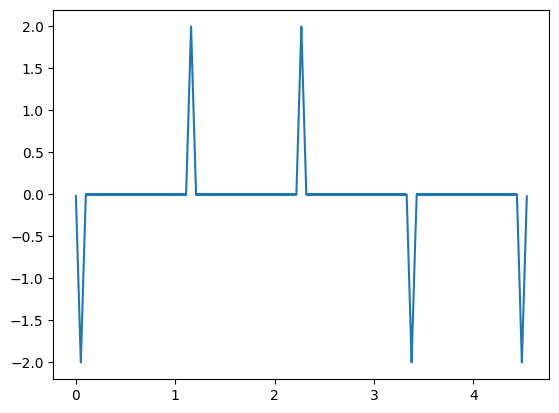

In [60]:
plt.plot(time_arr, voltage_arr)

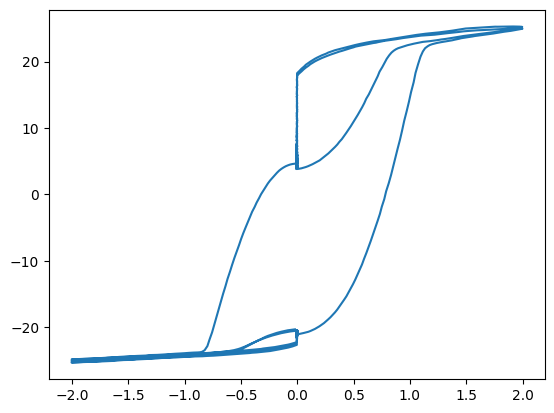

In [61]:
plt.plot(voltage_arr, polaraization_arr)

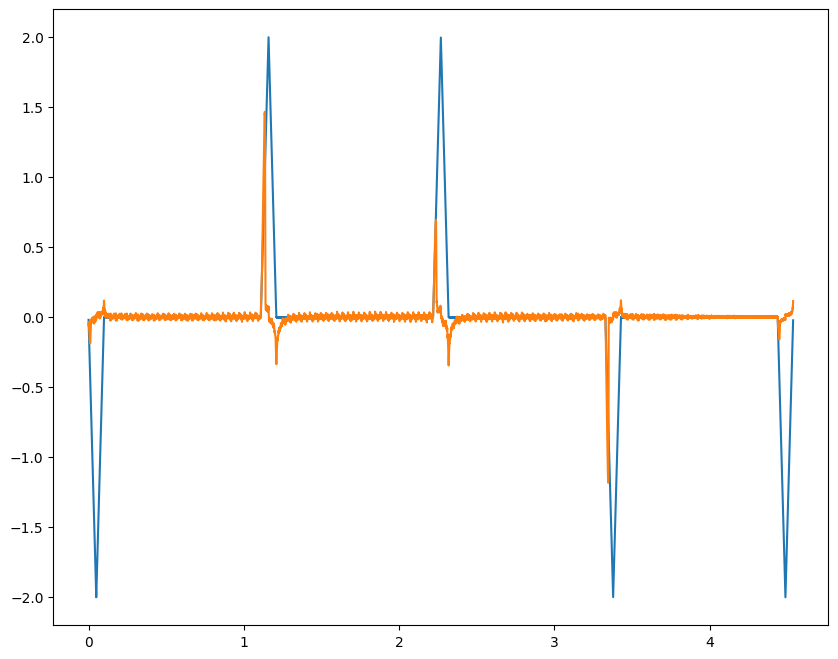

In [62]:
plt.figure(figsize=(10, 8))
plt.plot(time_arr, voltage_arr)
plt.plot(time_arr, 5*current_arr)

SO now basically we want to take the first pulse and subtract hte second pulse. so we need to find peaks! (actually its start and end of the each pulse train)
seems easier to just hard code it since we know the waveform

In [63]:
def find_peaks_troughs_index(arr):
    arr_normalized = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    peaks, _ = find_peaks(arr_normalized, height=0.8)
    troughs, _ = find_peaks(-1*arr_normalized, height=0.8)
    all_peaks = np.concatenate((peaks, troughs), axis=0)
    return all_peaks

my_peaks = np.sort(find_peaks_troughs_index(voltage_arr))

In [64]:
pulse_width_points = 200 #data points


In [65]:
my_peaks

array([  99, 2318, 4537, 6756, 8975], dtype=int64)

In [66]:
start_arr = my_peaks - 99
start_arr

array([   0, 2219, 4438, 6657, 8876], dtype=int64)

In [67]:
end_arr = my_peaks + 99
end_arr

array([ 198, 2417, 4636, 6855, 9074], dtype=int64)

In [68]:
#Get the start and end of each pulse sequence

valid_start = start_arr[1:] #this will have to change if i done have the first negative pulse
valid_end = end_arr[1:]
start_pos = valid_start[0]
end_pos = valid_end[0]
start_pos_residual = valid_start[1]
end_pos_residual = valid_end[1]
start_neg = valid_start[2]
end_neg = valid_end[2]
start_neg_residual = valid_start[3]
end_neg_residual = valid_end[3]


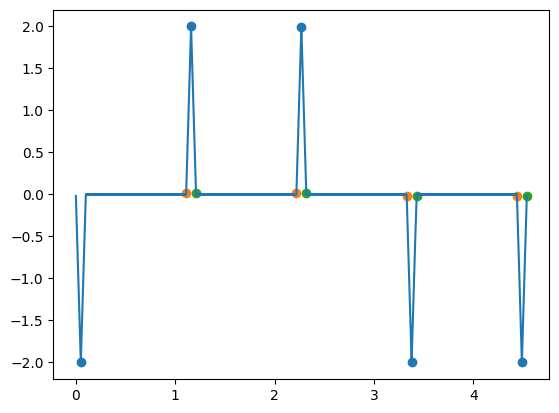

In [69]:
#sanity check plot these points
plt.plot(time_arr, voltage_arr)
plt.scatter(time_arr[my_peaks], voltage_arr[my_peaks])
plt.scatter(time_arr[valid_start], voltage_arr[valid_start])
plt.scatter(time_arr[valid_end], voltage_arr[valid_end])

In [ ]:
#subtract I1-I2 and I3- I4

i1_sub_i2 = current_arr[start_pos:end_pos] - current_arr[start_pos_residual:end_pos_residual]
i3_sub_i4 = current_arr[start_neg:end_neg] - current_arr[start_neg_residual:end_neg_residual]


In [76]:
#now plot new current waveform and then we need to integrate etc
#first get new voltage array and combine the current arrays
modified_curr_arr = np.concatenate([i1_sub_i2, i3_sub_i4])
modified_time_arr = np.concatenate([time_arr[start_pos:end_pos], time_arr[start_neg:end_neg]])
modified_voltage_arr = np.concatenate([voltage_arr[start_pos:end_pos], voltage_arr[start_neg:end_neg]])


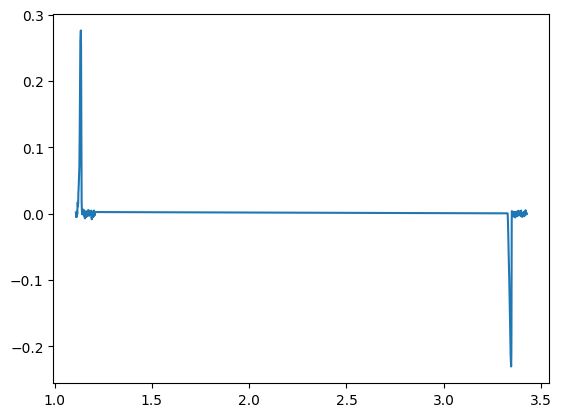

In [75]:
plt.plot(modified_time_arr, modified_curr_arr)

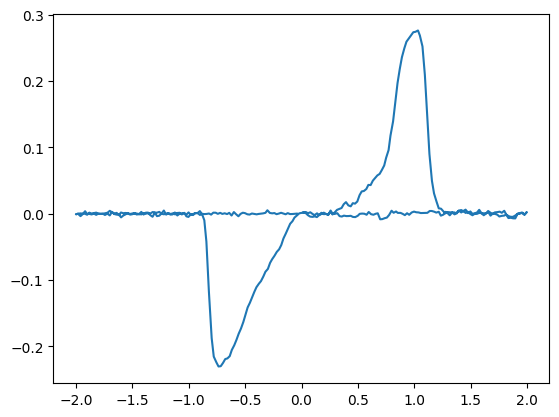

In [77]:
plt.plot(modified_voltage_arr, modified_curr_arr)

In [ ]:
#now integrate
wfm_q = it.cumulative_trapezoid(modified_curr_arr, modified_time_arr, initial=0) 
wfm_idk = it.cumulative_trapezoid(modified_voltage_arr, modified_time_arr, initial=0) 


396


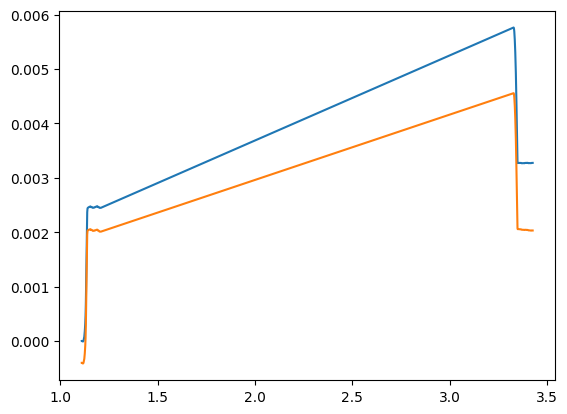

In [86]:
plt.plot(modified_time_arr, wfm_q)
#need to drift correct?
print(len(wfm_q))
slope = (wfm_q[300] - wfm_q[100])/(modified_time_arr[300]-modified_time_arr[100])
wfm_q_drift_corrected = []
for i in range(len(wfm_q)):
    wfm_q_drift_corrected.append(wfm_q[i]-(slope*modified_time_arr[i]))
plt.plot(modified_time_arr, wfm_q_drift_corrected)

0.0045562754228040655


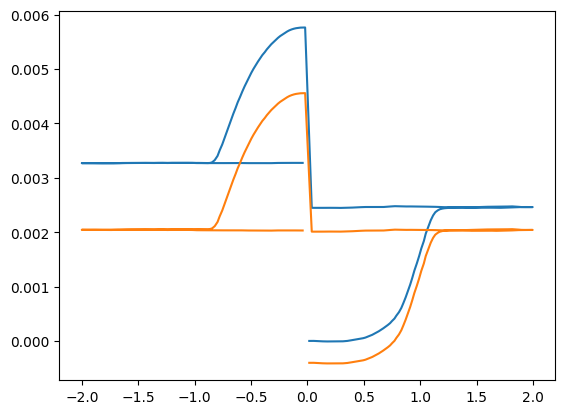

In [115]:
plt.plot(modified_voltage_arr, wfm_q)
plt.plot(modified_voltage_arr, wfm_q_drift_corrected)
print(np.max(wfm_q_drift_corrected))

In [90]:
#try doing the integral seperate and combining at the end?
wfm_q_pos = it.cumulative_trapezoid(i1_sub_i2, time_arr[start_pos:end_pos], initial=0)
wfm_q_neg = it.cumulative_trapezoid(i3_sub_i4, time_arr[start_pos:end_pos], initial=0)
wfm_q_frankestein = np.concatenate([wfm_q_pos, wfm_q_neg])

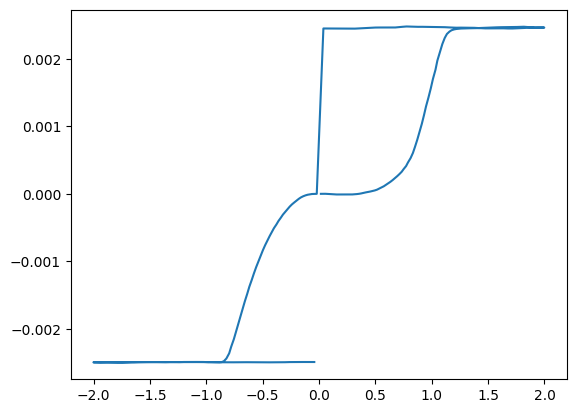

In [91]:
plt.plot(modified_voltage_arr, wfm_q_frankestein)

In [138]:
#new strat just manually align the two
neg_polled = modified_voltage_arr.argmin()
pos_polled = modified_voltage_arr.argmax()
#now for the left hand side which is the 2nd half of the array
one = wfm_q_drift_corrected[:int(len(wfm_q_drift_corrected)/2)] 
two = wfm_q_drift_corrected[int(len(wfm_q_drift_corrected)/2):] 
offset = np.array(two).max() - np.array(two).min()
pieced_wfm_q = np.concatenate([one + offset, two]) #im adding the wrong parts of it argh

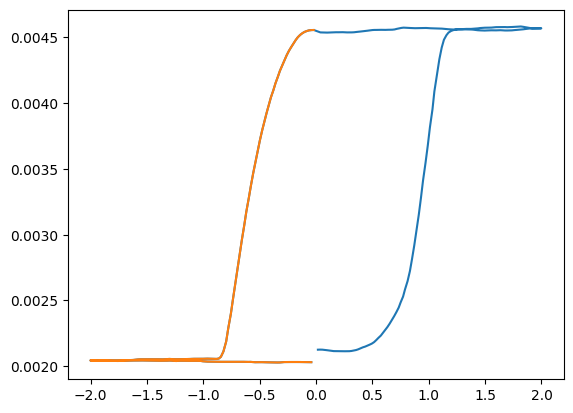

In [140]:
plt.plot(modified_voltage_arr, pieced_wfm_q)
##plt.plot(modified_voltage_arr[:int(len(wfm_q_drift_corrected)/2)], one, color='green')
plt.plot(modified_voltage_arr[int(len(wfm_q_drift_corrected)/2):], two)

In [134]:
np.array(one).argmax()

90

In [137]:
offset = np.array(two).max() - np.array(two).min()

0.0025279405667792843